# **Please Please final one**

In [5]:
!pip install numpy==1.24.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 91.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib
import os

# 1. Centralized Configuration
"""
This dictionary holds all hyperparameters and settings for the training process.
Modifying these values will directly impact the model's architecture, data handling,
and training behavior.
"""
CONFIG = {
    # Data and Target Specification
    "train_data_path": "/content/drive/MyDrive/traindata.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],

    # Model Architecture
    "window_size": 50,      
    "future_steps": 1200,   
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.3,
    "model_type": "BiLSTM",

    # Training Parameters
    "learning_rate": 0.001,
    "weight_decay": 1e-5,
    "batch_size": 32,
    "num_epochs": 200,
    "early_stopping_patience": 3,
    "validation_split": 0.2,
}
# The model's output layer size is derived from the number of targets and future steps.
CONFIG["output_size"] = len(CONFIG["target_columns"]) * CONFIG["future_steps"]


# 2. Data Preparation
"""
This section contains functions and classes for preparing the time series data
for the direct multi-step forecasting model.
"""

def create_direct_sequences(data, target_column_indices, window_size, future_steps):
    """
    Creates sequences where X is the history and y is the entire future trajectory.
    The future trajectory is flattened into a single target vector.
    """
    X, y = [], []
    num_samples = len(data) - window_size - future_steps + 1

    if num_samples <= 0:
        raise ValueError(
            f"Not enough data to create sequences. "
            f"Total data points: {len(data)}, Window size: {window_size}, Future steps: {future_steps}. "
            f"Need at least {window_size + future_steps} data points."
        )

    for i in range(num_samples):
        # Input sequence (the history)
        X.append(data[i : i + window_size, :])

        # Output sequence (the entire future, flattened)
        future_sequence = data[i + window_size : i + window_size + future_steps, target_column_indices]
        y.append(future_sequence.flatten())

    return np.array(X), np.array(y)


class TimeSeriesDataset(Dataset):
    """A custom PyTorch Dataset for handling time series sequence data."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 3. Model Architecture
"""
This section defines the neural network architecture for the direct forecasting model.
"""
class BiLSTMModel(nn.Module):
    """
    A Bidirectional LSTM model that takes a historical window and predicts
    a flattened vector representing the entire future sequence in one shot.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # The final fully connected layer maps the LSTM output to the desired future sequence size.
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We use the output of the final time step from the historical sequence to make the prediction.
        out = self.fc(lstm_out[:, -1, :])
        return out


# 4. Training Function
"""
This section contains the main training loop, including validation,
model saving, and early stopping logic.
"""
def train_model(model, config, train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=config["early_stopping_patience"] // 2, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    model_save_path = f"model_{config['model_type']}.pth"

    print(f"Starting Training for {config['model_type']} (Direct Multi-Step Method)")
    for epoch in range(config["num_epochs"]):
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        scheduler.step(avg_val_loss)

        # Early stopping and model saving logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
            print(f"    => New best model saved to '{model_save_path}' with validation loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1

        if patience_counter >= config['early_stopping_patience']:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    print("Training Complete")


# 5. Main Execution Block
"""
This main function orchestrates the entire process: loading data, scaling,
creating sequences, splitting data, and initiating the model training.
"""
def main():
    try:
        dff_train = pd.read_csv(CONFIG["train_data_path"])
        dff_train_numeric = dff_train.select_dtypes(include=[np.number])
    except FileNotFoundError:
        print(f"FATAL: Training data file not found at '{CONFIG['train_data_path']}'.")
        return

    # Validate that all specified target columns exist in the dataframe
    for col in CONFIG["target_columns"]:
        if col not in dff_train_numeric.columns:
            print(f"FATAL: Target column '{col}' not found in the training data.")
            return

    # Scale the data and save the scaler for later use
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dff_train_numeric)
    joblib.dump(scaler, "main_scaler.joblib")
    print("Main scaler saved to 'main_scaler.joblib'")

    # Create the specialized sequences for direct forecasting
    target_col_indices = [dff_train_numeric.columns.get_loc(c) for c in CONFIG["target_columns"]]
    try:
        Xt, yt = create_direct_sequences(data_scaled, target_col_indices, CONFIG["window_size"], CONFIG["future_steps"])
    except ValueError as e:
        print(f"FATAL: Error creating sequences: {e}")
        return

    # Split the data into training and validation sets
    split_index = int(len(Xt) * (1 - CONFIG["validation_split"]))
    if split_index == 0 or split_index == len(Xt):
        print("FATAL: Validation split resulted in an empty training or validation set.")
        return

    X_train, X_val = Xt[:split_index], Xt[split_index:]
    y_train, y_val = yt[:split_index], yt[split_index:]

    # Create PyTorch Datasets and DataLoaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

    # Initialize and train the model
    input_size = X_train.shape[2]
    model = BiLSTMModel(
        input_size=input_size,
        hidden_size=CONFIG["hidden_size"],
        num_layers=CONFIG["num_layers"],
        output_size=CONFIG["output_size"],
        dropout=CONFIG["dropout"]
    )
    train_model(model, CONFIG, train_loader, val_loader)


if __name__ == '__main__':
    main()

Main scaler saved to 'main_scaler.joblib'
Using device: cuda
Starting Training for BiLSTM (Direct Multi-Step Method)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.431995, Val Loss: 1.293121
    => New best model saved to 'model_BiLSTM.pth' with validation loss: 1.293121
Epoch [2/200], Train Loss: 0.215762, Val Loss: 1.278484
    => New best model saved to 'model_BiLSTM.pth' with validation loss: 1.278484
Epoch [3/200], Train Loss: 0.162583, Val Loss: 1.328278
Epoch [4/200], Train Loss: 0.137309, Val Loss: 1.325003
Epoch [5/200], Train Loss: 0.108449, Val Loss: 1.332489
Early stopping triggered at epoch 5.
Training Complete


--- Starting Multi-Point RUL Forecast Analysis ---
Model and scaler loaded successfully.
Test data loaded. 8734 possible forecast starting points available.

Please enter 6 different starting points for the RUL forecast.
Enter starting point 1/6 (0 - 8733): 1000
Enter starting point 2/6 (0 - 8733): 8000
Enter starting point 3/6 (0 - 8733): 3000
Enter starting point 4/6 (0 - 8733): 4000
Enter starting point 5/6 (0 - 8733): 600
Enter starting point 6/6 (0 - 8733): 400

Forecasting from sequence starting at index: 1000...
  => SUCCESS: Predicted RUL is 203 steps.


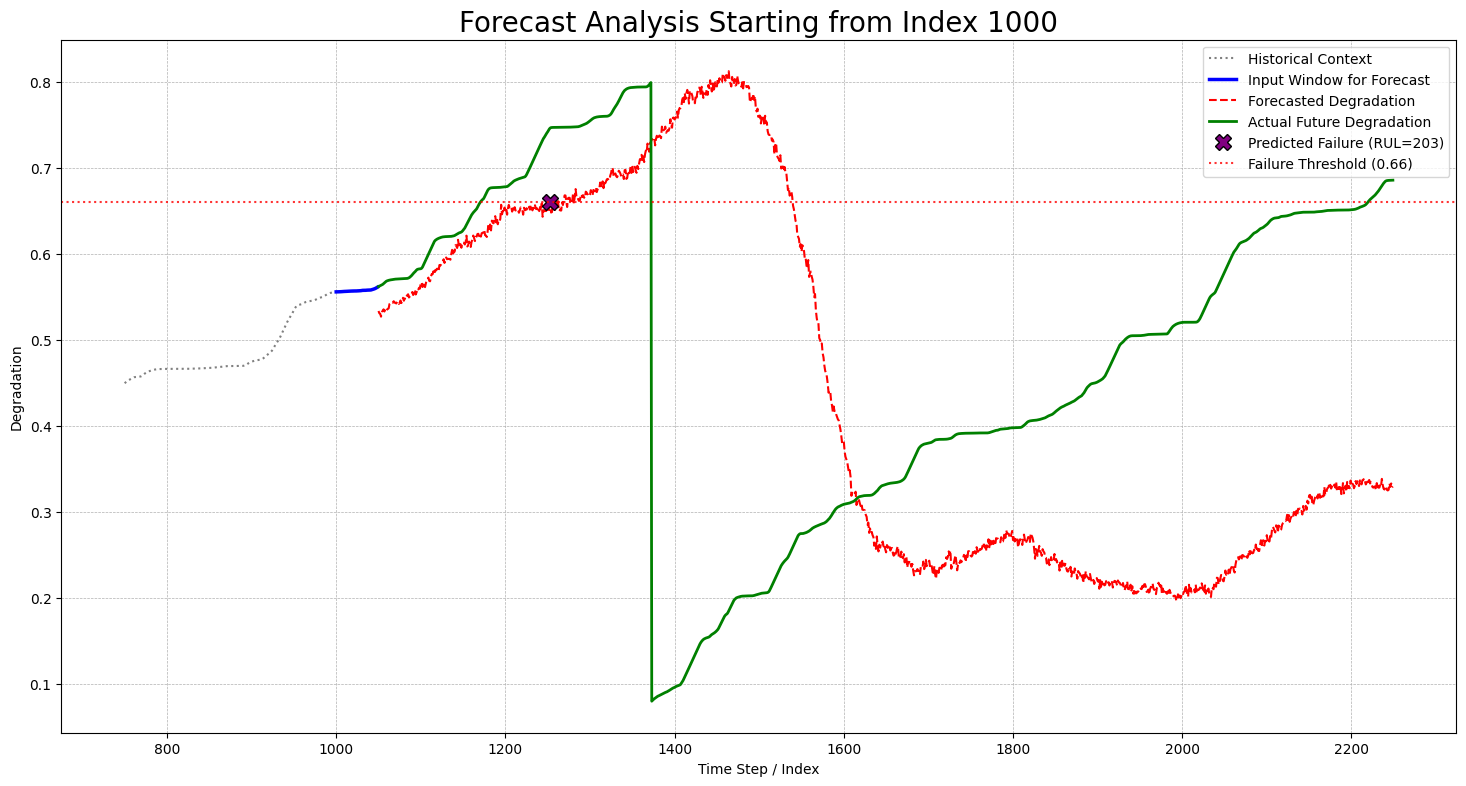


Forecasting from sequence starting at index: 8000...
  => SUCCESS: Predicted RUL is 191 steps.


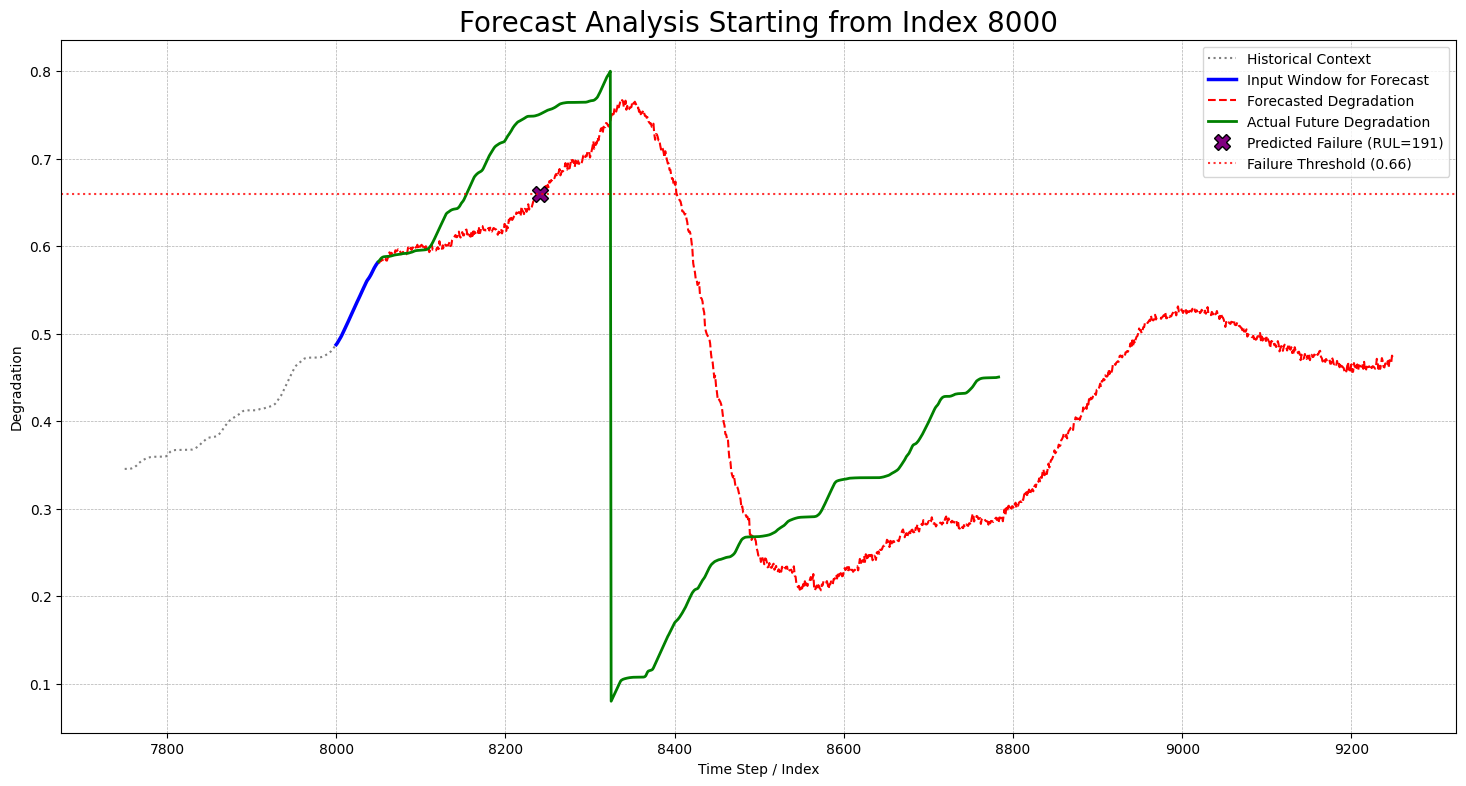


Forecasting from sequence starting at index: 3000...
  => SUCCESS: Predicted RUL is 776 steps.


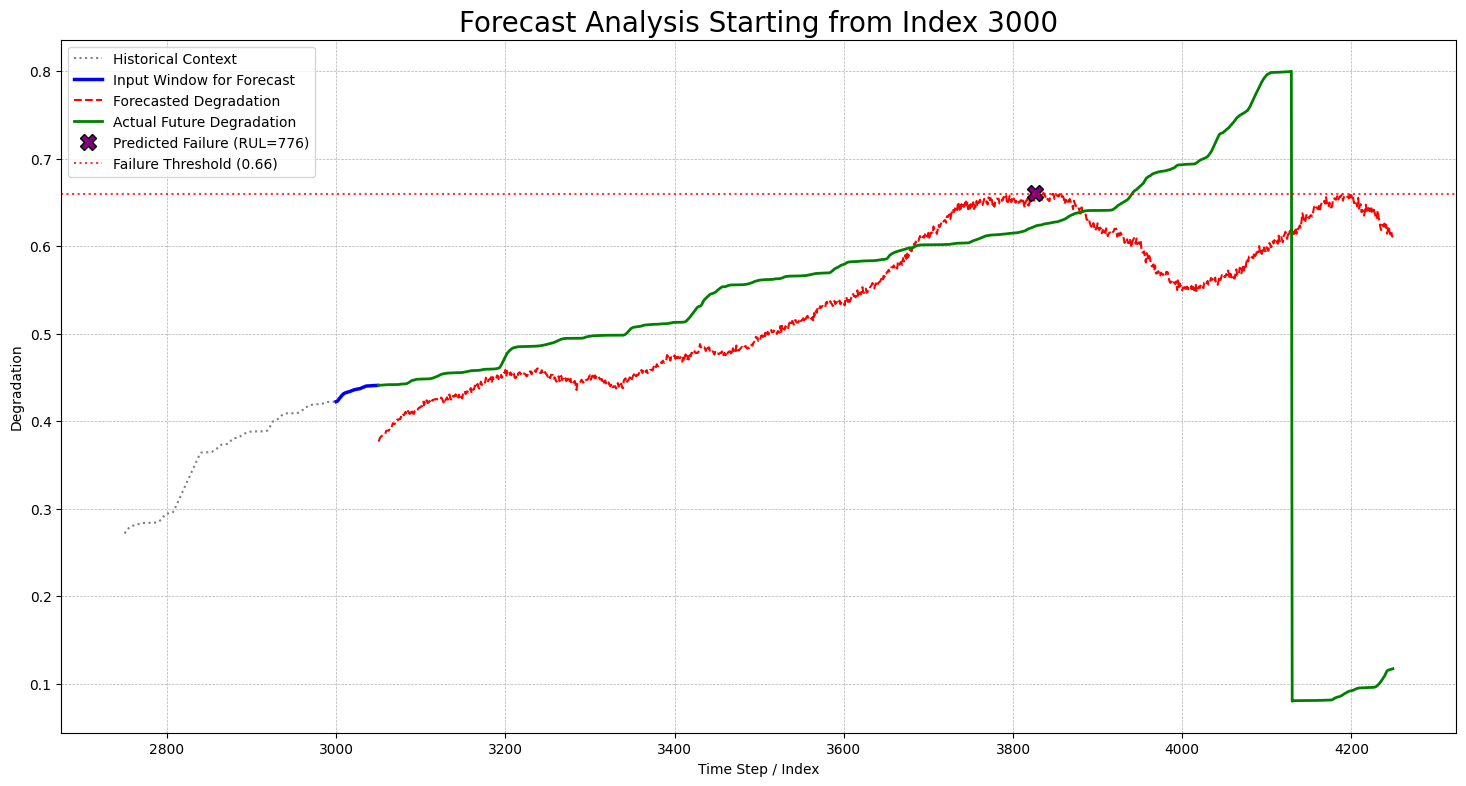


Forecasting from sequence starting at index: 4000...
  => SUCCESS: Predicted RUL is 4 steps.


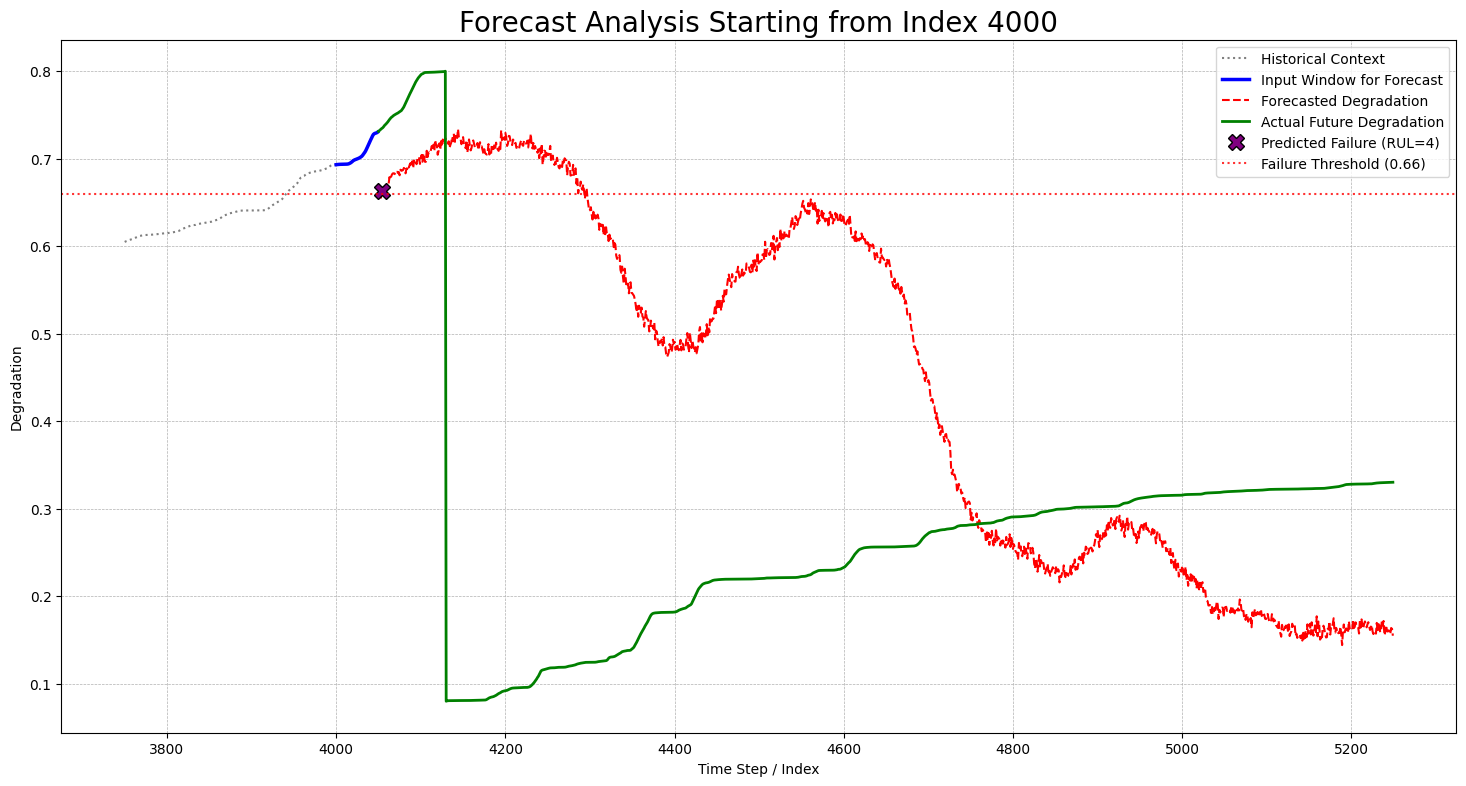


Forecasting from sequence starting at index: 600...
  => SUCCESS: Predicted RUL is 553 steps.


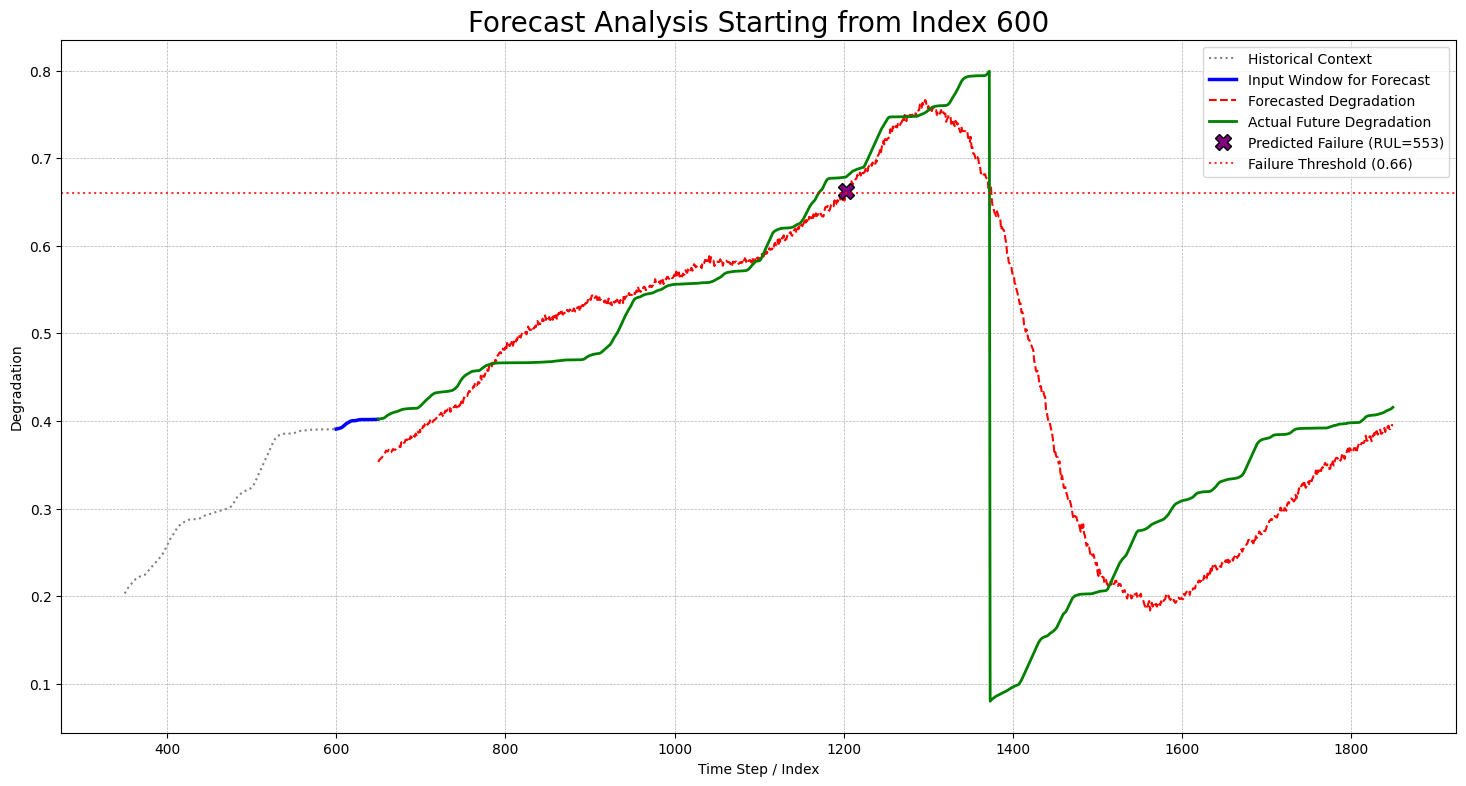


Forecasting from sequence starting at index: 400...
  => NOTE: Degradation did not reach threshold. RUL > 1200 steps.


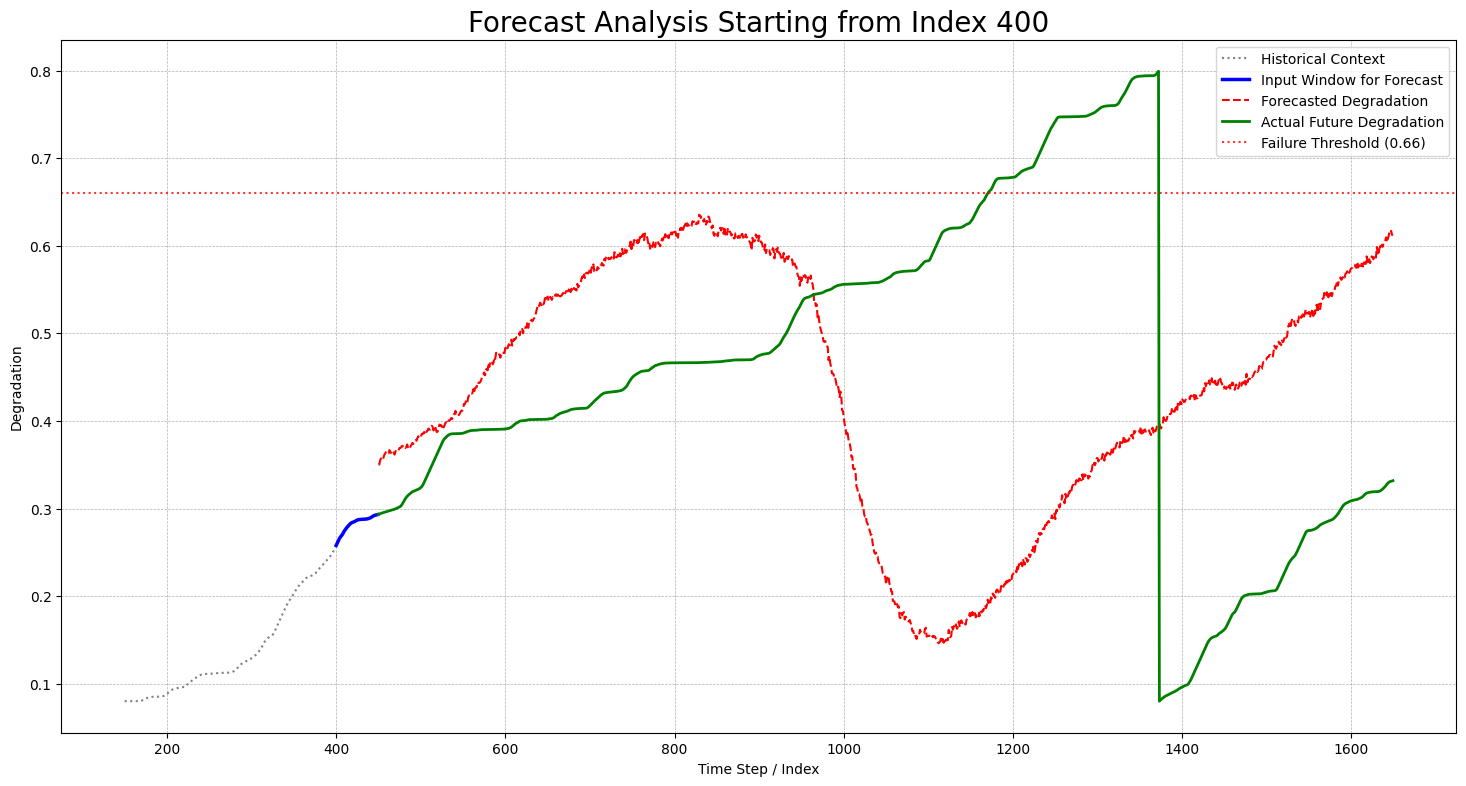

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib

# 1. Configuration for Analysis
"""
Holds all parameters for running the analysis. These settings must exactly
match the configuration of the trained model to ensure correct loading and
accurate evaluation.
"""
ANALYSIS_CONFIG = {
    "model_path": "model_BiLSTM.pth",
    "model_type": "BiLSTM",
    "scaler_path": "main_scaler.joblib",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],
    "window_size": 50,
    "future_steps": 1200,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.3, 
    "degradation_threshold": 0.66,
}
# Derived configuration, calculated automatically.
ANALYSIS_CONFIG["output_size"] = len(ANALYSIS_CONFIG["target_columns"]) * ANALYSIS_CONFIG["future_steps"]


# 2. Model Architecture
"""
This class defines the structure of the model. It must be identical to the
one used for training to allow for correct weight loading.
"""
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


# 3. Helper Functions
"""
This section contains helper functions for creating data sequences and running
the forecast.
"""

def forecast_rul_direct(model, start_sequence, scaler, config):
    """
    Performs a direct, one-shot forecast for the entire future window.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # The input sequence needs a batch dimension (B, L, H) -> (1, L, H)
    input_tensor = torch.tensor(start_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        flat_prediction_scaled = model(input_tensor)

    # Reshape the flat output vector back to (future_steps, num_targets)
    num_targets = len(config["target_columns"])
    prediction_scaled = flat_prediction_scaled.cpu().numpy().reshape(config["future_steps"], num_targets)

    # To unscale predictions, we must reconstruct the full feature array.
    prediction_full = np.zeros((config["future_steps"], len(scaler.feature_names_in_)))
    target_indices = [list(scaler.feature_names_in_).index(c) for c in config["target_columns"]]

    # Place the predicted values into the correct columns.
    prediction_full[:, target_indices] = prediction_scaled

    # Unscale the entire predicted trajectory.
    prediction_unscaled = scaler.inverse_transform(prediction_full)

    # Extract just the degradation column for RUL calculation.
    degradation_col_idx_in_targets = config["target_columns"].index("degradation")
    degradation_col_idx_overall = target_indices[degradation_col_idx_in_targets]
    forecasted_degradation = prediction_unscaled[:, degradation_col_idx_overall]

    return forecasted_degradation


# 4. Main Execution Block
"""
This main function orchestrates the analysis process: loading artifacts,
processing test data, and running forecasts from user-defined starting points.
"""
def run_multi_forecast_analysis():
    print("--- Starting Multi-Point RUL Forecast Analysis ---")

    # Load scaler and model
    try:
        scaler = joblib.load(ANALYSIS_CONFIG["scaler_path"])
        model = BiLSTMModel(
            input_size=len(scaler.feature_names_in_),
            hidden_size=ANALYSIS_CONFIG["hidden_size"],
            num_layers=ANALYSIS_CONFIG["num_layers"],
            output_size=ANALYSIS_CONFIG["output_size"],
            dropout=ANALYSIS_CONFIG["dropout"]
        )
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(ANALYSIS_CONFIG["model_path"], map_location=device))
        print("Model and scaler loaded successfully.")
    except Exception as e:
        print(f"FATAL: Could not load model or scaler. Error: {e}")
        return

    # Load and process data
    try:
        dff_test = pd.read_csv(ANALYSIS_CONFIG["test_data_path"])
        dff_test_numeric = dff_test.select_dtypes(include=[np.number])
        test_aligned = dff_test_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
        test_scaled = scaler.transform(test_aligned)

        # Create all possible input sequences from the test data
        X_test = np.array([test_scaled[i:i+ANALYSIS_CONFIG["window_size"]] for i in range(len(test_scaled) - ANALYSIS_CONFIG["window_size"])])
        print(f"Test data loaded. {len(X_test)} possible forecast starting points available.")
    except Exception as e:
        print(f"FATAL: Error processing test data: {e}.")
        return

    # Interactively get 6 forecast points from the user
    start_points = []
    print("\nPlease enter 6 different starting points for the RUL forecast.")
    while len(start_points) < 6:
        try:
            point = int(input(f"Enter starting point {len(start_points) + 1}/6 (0 - {len(X_test)-1}): "))
            if 0 <= point < len(X_test):
                start_points.append(point)
            else:
                print(f"Invalid input. Please enter a number between 0 and {len(X_test)-1}.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

    # Run forecast for each point and generate a separate plot
    for start_index in start_points:
        print(f"\nForecasting from sequence starting at index: {start_index}...")
        start_sequence = X_test[start_index]
        forecasted_degradation = forecast_rul_direct(model, start_sequence, scaler, ANALYSIS_CONFIG)

        try:
            predicted_rul = np.where(forecasted_degradation >= ANALYSIS_CONFIG["degradation_threshold"])[0][0]
            print(f"  => SUCCESS: Predicted RUL is {predicted_rul} steps.")
        except IndexError:
            predicted_rul = ANALYSIS_CONFIG["future_steps"]
            print(f"  => NOTE: Degradation did not reach threshold. RUL > {predicted_rul} steps.")

        # Create a new, separate plot for this specific forecast
        plt.figure(figsize=(18, 9))
        plt.title(f'Forecast Analysis Starting from Index {start_index}', fontsize=20)
        plt.xlabel('Time Step / Index')
        plt.ylabel('Degradation')

        absolute_start_point = ANALYSIS_CONFIG["window_size"] + start_index

        # Plot the historical context leading up to the forecast point
        history_context_points = 300
        context_start = max(0, absolute_start_point - history_context_points)
        context_to_plot = test_aligned.iloc[context_start:absolute_start_point]
        plt.plot(context_to_plot.index, context_to_plot['degradation'], color='gray', linestyle=':', label='Historical Context')

        # Highlight the specific window of data the model used as input
        input_window_start = absolute_start_point - ANALYSIS_CONFIG["window_size"]
        input_window_to_plot = test_aligned.iloc[input_window_start:absolute_start_point]
        plt.plot(input_window_to_plot.index, input_window_to_plot['degradation'], 'b-', linewidth=2.5, label='Input Window for Forecast')

        # Plot the model's forecasted degradation curve
        forecast_x_axis = np.arange(absolute_start_point, absolute_start_point + ANALYSIS_CONFIG["future_steps"])
        plt.plot(forecast_x_axis, forecasted_degradation, 'r--', label='Forecasted Degradation')

        # Plot the actual future degradation from the test data for comparison
        actual_future_end = min(len(test_aligned), absolute_start_point + ANALYSIS_CONFIG["future_steps"])
        actual_future_to_plot = test_aligned.iloc[absolute_start_point:actual_future_end]
        plt.plot(actual_future_to_plot.index, actual_future_to_plot['degradation'], 'g-', linewidth=2, label='Actual Future Degradation')

        # Plot the predicted failure point if it was found within the forecast horizon
        if predicted_rul < ANALYSIS_CONFIG["future_steps"]:
            failure_point_x = absolute_start_point + predicted_rul
            failure_point_y = forecasted_degradation[predicted_rul]
            plt.plot(failure_point_x, failure_point_y, 'X', color='purple', markersize=12, markeredgecolor='black', label=f'Predicted Failure (RUL={predicted_rul})')

        plt.axhline(y=ANALYSIS_CONFIG["degradation_threshold"], color='red', linestyle=':', alpha=0.8, label=f'Failure Threshold ({ANALYSIS_CONFIG["degradation_threshold"]})')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()


if __name__ == '__main__':
    run_multi_forecast_analysis()


--- Starting RUL Forecast (Direct Method) ---
Scaler loaded from 'main_scaler.joblib'
Test data loaded. Forecasting from sequence starting at index: 0
Model 'BiLSTM' loaded from 'model_BiLSTM.pth'

Forecasting future degradation curve...
NOTE: Degradation does not reach the threshold within the next 1200 steps.


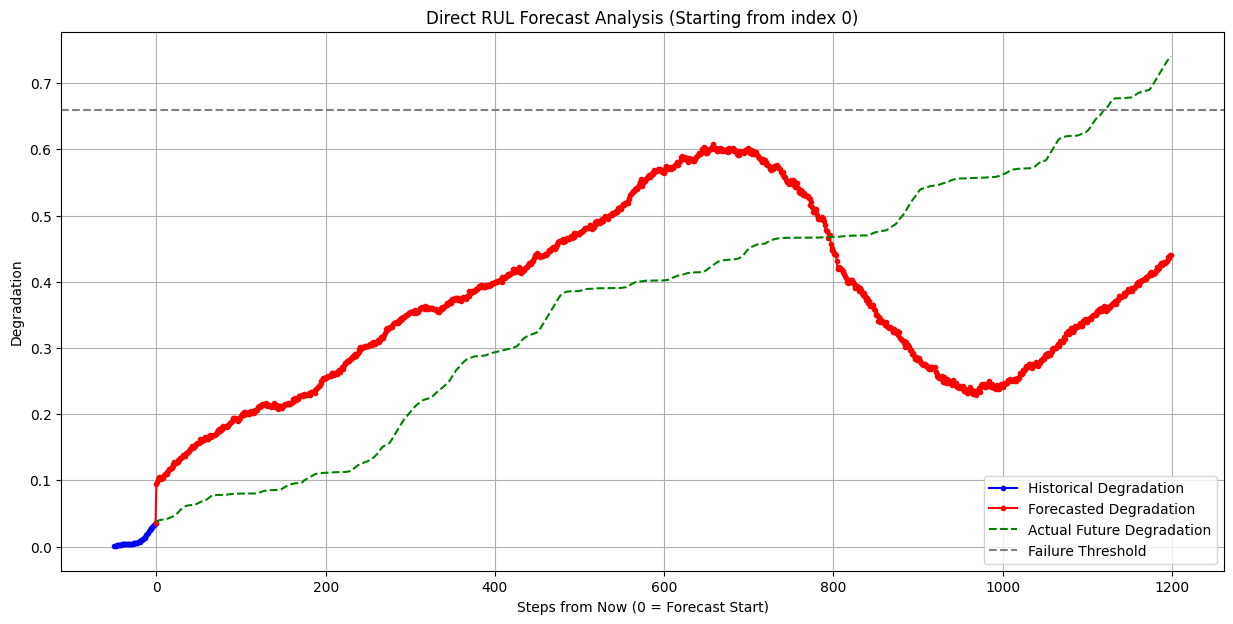


--- Analysis Complete ---


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib

# 1. Configuration for Forecasting
"""
Holds all parameters for running the forecast. These settings must exactly
match the configuration of the trained model to ensure correct loading and
accurate evaluation.
"""
FORECAST_CONFIG = {
    "model_path": "model_BiLSTM.pth",
    "model_type": "BiLSTM",
    "scaler_path": "main_scaler.joblib",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],
    "window_size": 50,
    "future_steps": 1200,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.2,
    "degradation_threshold": 0.66,
    "forecast_start_index": 0
}
# Derived configuration, calculated automatically.
FORECAST_CONFIG["output_size"] = len(FORECAST_CONFIG["target_columns"]) * FORECAST_CONFIG["future_steps"]


# 2. Model Architecture
"""
This class defines the structure of the model. It must be identical to the
one used for training to allow for correct weight loading.
"""
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # The final layer maps the bidirectional LSTM output to the flattened prediction vector.
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We use the output from the last time step of the input sequence to make the forecast.
        out = self.fc(lstm_out[:, -1, :])
        return out


# 3. Helper Functions
"""
This section contains helper functions for creating data sequences and running
the forecast.
"""
def create_input_sequence(data, window_size):
    """Creates all possible historical sequences (X) from the provided data."""
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
    return np.array(X)


def forecast_rul_direct(model, start_sequence, scaler, config):
    """
    Performs a direct, one-shot forecast for the entire future window.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # The input sequence requires a batch dimension for the model.
    input_tensor = torch.tensor(start_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        flat_prediction_scaled = model(input_tensor)

    # Reshape the flat output vector back to (future_steps, num_targets).
    num_targets = len(config["target_columns"])
    prediction_scaled = flat_prediction_scaled.cpu().numpy().reshape(config["future_steps"], num_targets)

    # To unscale predictions, we must reconstruct the full feature array.
    prediction_full = np.zeros((config["future_steps"], len(scaler.feature_names_in_)))
    target_indices = [list(scaler.feature_names_in_).index(c) for c in config["target_columns"]]

    # Place the predicted values into the correct columns.
    prediction_full[:, target_indices] = prediction_scaled

    prediction_unscaled = scaler.inverse_transform(prediction_full)

    # Extract just the degradation column for RUL calculation.
    degradation_col_idx_in_targets = config["target_columns"].index("degradation")
    degradation_col_idx_overall = target_indices[degradation_col_idx_in_targets]
    forecasted_degradation = prediction_unscaled[:, degradation_col_idx_overall]

    return forecasted_degradation


# 4. Main Execution Block
"""
This main function orchestrates the analysis process: loading artifacts,
processing test data, and running a forecast from a defined starting point.
"""
def run_forecast():
    print("--- Starting RUL Forecast (Direct Method) ---")

    try:
        scaler = joblib.load(FORECAST_CONFIG["scaler_path"])
        print(f"Scaler loaded from '{FORECAST_CONFIG['scaler_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Scaler file not found at '{FORECAST_CONFIG['scaler_path']}'.")
        return

    try:
        dff_test = pd.read_csv(FORECAST_CONFIG["test_data_path"])
        dff_test_numeric = dff_test.select_dtypes(include=[np.number])
        test_aligned = dff_test_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
        test_scaled = scaler.transform(test_aligned)
        X_test = create_input_sequence(test_scaled, FORECAST_CONFIG["window_size"])

        start_index = FORECAST_CONFIG["forecast_start_index"]
        if not (0 <= start_index < len(X_test)):
            print(f"FATAL: 'forecast_start_index' ({start_index}) is out of bounds. Valid range: 0 to {len(X_test)-1}.")
            return

        start_sequence = X_test[start_index]
        print(f"Test data loaded. Forecasting from sequence starting at index: {start_index}")

    except Exception as e:
        print(f"FATAL: Error processing test data: {e}.")
        return

    # Initialize the model with the correct architecture.
    model = BiLSTMModel(
        input_size=start_sequence.shape[1],
        hidden_size=FORECAST_CONFIG["hidden_size"],
        num_layers=FORECAST_CONFIG["num_layers"],
        output_size=FORECAST_CONFIG["output_size"],
        dropout=FORECAST_CONFIG["dropout"]
    )

    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(FORECAST_CONFIG["model_path"], map_location=device))
        print(f"Model '{FORECAST_CONFIG['model_type']}' loaded from '{FORECAST_CONFIG['model_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Model file not found. Have you run the training script?")
        return

    print("\nForecasting future degradation curve...")
    forecasted_degradation = forecast_rul_direct(model, start_sequence, scaler, FORECAST_CONFIG)

    # Calculate RUL (Remaining Useful Life).
    try:
        # Find the first point where the forecast crosses the degradation threshold.
        rul = np.where(forecasted_degradation >= FORECAST_CONFIG["degradation_threshold"])[0][0]
        print(f"SUCCESS: Predicted RUL is {rul} steps.")
    except IndexError:
        # This occurs if the threshold is never reached in the forecast window.
        rul = FORECAST_CONFIG['future_steps']
        print(f"NOTE: Degradation does not reach the threshold within the next {rul} steps.")

    # Plotting the forecast and actuals.
    plt.figure(figsize=(15, 7))

    # Define the absolute index in the original data where the forecast starts.
    absolute_start_point_for_plot = FORECAST_CONFIG["window_size"] + start_index

    # 1. Plot historical data leading up to the forecast point.
    num_history_points = 200
    history_start_point = max(0, absolute_start_point_for_plot - num_history_points)
    historical_degradation_to_plot = test_aligned['degradation'].values[history_start_point:absolute_start_point_for_plot]
    history_x_axis = np.arange(-len(historical_degradation_to_plot), 0)
    plt.plot(history_x_axis, historical_degradation_to_plot, 'b.-', label='Historical Degradation')

    # 2. Plot the direct forecast, connected to the last historical point.
    last_historical_point = historical_degradation_to_plot[-1]
    plot_forecast_y = np.insert(forecasted_degradation, 0, last_historical_point)
    plot_forecast_x = np.arange(-1, FORECAST_CONFIG['future_steps'])
    plt.plot(plot_forecast_x, plot_forecast_y, 'r.-', label='Forecasted Degradation')

    # 3. Plot the real future degradation from test data for comparison.
    real_future_end_idx = min(len(test_aligned), absolute_start_point_for_plot + FORECAST_CONFIG['future_steps'])
    real_future_degradation_to_plot = test_aligned['degradation'].values[absolute_start_point_for_plot : real_future_end_idx]
    real_future_x_axis = np.arange(0, len(real_future_degradation_to_plot))
    plt.plot(real_future_x_axis, real_future_degradation_to_plot, 'g--', label='Actual Future Degradation')

    # 4. Plot degradation threshold and RUL lines.
    plt.axhline(y=FORECAST_CONFIG["degradation_threshold"], color='gray', linestyle='--', label='Failure Threshold')
    if rul < FORECAST_CONFIG['future_steps']:
        plt.axvline(x=rul, color='purple', linestyle='--', label=f'Predicted RUL ({rul} steps)')

    plt.title(f'Direct RUL Forecast Analysis (Starting from index {start_index})')
    plt.xlabel('Steps from Now (0 = Forecast Start)')
    plt.ylabel('Degradation')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("\n--- Analysis Complete ---")


if __name__ == '__main__':
    run_forecast()

Starting RUL Forecast (Direct Method)
Scaler loaded from 'main_scaler.joblib'
Test data loaded. Forecasting from sequence starting at index: 1000
Model 'BiLSTM' loaded from 'model_BiLSTM.pth'

Forecasting future degradation curve...
SUCCESS: Predicted RUL is 203 steps.


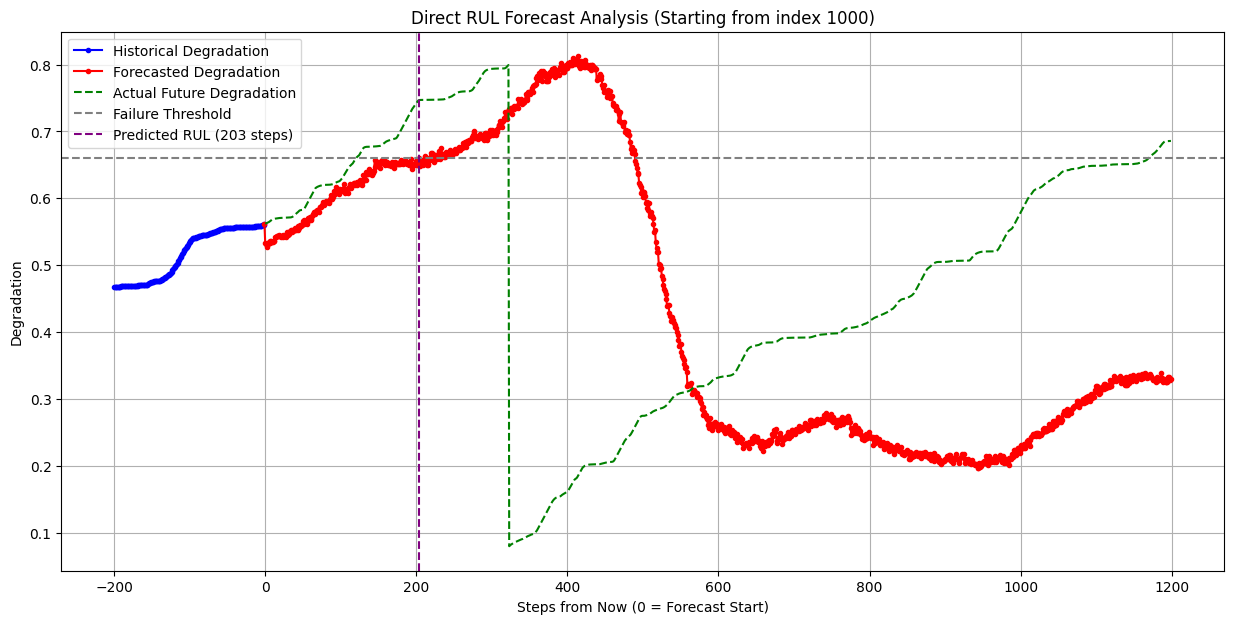


--- Analysis Complete ---


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib

# 1. Configuration for Forecasting
"""
Holds all parameters for running the forecast. These settings must exactly
match the configuration of the trained model to ensure correct loading and
accurate evaluation.
"""
FORECAST_CONFIG = {
    "model_path": "model_BiLSTM.pth",
    "model_type": "BiLSTM",
    "scaler_path": "main_scaler.joblib",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],
    "window_size": 50,
    "future_steps": 1200,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.2,
    "degradation_threshold": 0.66,
    "forecast_start_index": 1000
}
# Derived configuration, calculated automatically from the parameters above.
FORECAST_CONFIG["output_size"] = len(FORECAST_CONFIG["target_columns"]) * FORECAST_CONFIG["future_steps"]


# 2. Model Architecture
"""
This class defines the structure of the model. It must be identical to the
one used for training to allow for correct weight loading.
"""
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # The final layer maps the bidirectional LSTM output to the flattened prediction vector.
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We use the output from the last time step of the input sequence to make the forecast.
        out = self.fc(lstm_out[:, -1, :])
        return out


# 3. Helper Functions
"""
This section contains helper functions for creating data sequences and running
the forecast.
"""
def create_input_sequence(data, window_size):
    """Creates all possible historical sequences (X) from the provided data."""
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
    return np.array(X)


def forecast_rul_direct(model, start_sequence, scaler, config):
    """
    Performs a direct, one-shot forecast for the entire future window.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # The input sequence requires a batch dimension for the model.
    input_tensor = torch.tensor(start_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        flat_prediction_scaled = model(input_tensor)

    # Reshape the flat output vector back to (future_steps, num_targets).
    num_targets = len(config["target_columns"])
    prediction_scaled = flat_prediction_scaled.cpu().numpy().reshape(config["future_steps"], num_targets)

    # To unscale predictions, we must reconstruct the full feature array.
    prediction_full = np.full((config["future_steps"], len(scaler.feature_names_in_)), scaler.mean_)
    target_indices = [list(scaler.feature_names_in_).index(c) for c in config["target_columns"]]

    # Place the predicted values into the correct columns.
    prediction_full[:, target_indices] = prediction_scaled

    prediction_unscaled = scaler.inverse_transform(prediction_full)

    # Extract just the degradation column for RUL calculation.
    degradation_col_idx_in_targets = config["target_columns"].index("degradation")
    degradation_col_idx_overall = target_indices[degradation_col_idx_in_targets]
    forecasted_degradation = prediction_unscaled[:, degradation_col_idx_overall]

    return forecasted_degradation


# 4. Main Execution Block
"""
This main function orchestrates the analysis process: loading artifacts,
processing test data, and running a forecast from a defined starting point.
"""
def run_forecast():
    print("Starting RUL Forecast (Direct Method)")

    try:
        scaler = joblib.load(FORECAST_CONFIG["scaler_path"])
        print(f"Scaler loaded from '{FORECAST_CONFIG['scaler_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Scaler file not found at '{FORECAST_CONFIG['scaler_path']}'.")
        return

    try:
        dff_test = pd.read_csv(FORECAST_CONFIG["test_data_path"])
        dff_test_numeric = dff_test.select_dtypes(include=[np.number])
        test_aligned = dff_test_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
        test_scaled = scaler.transform(test_aligned)
        X_test = create_input_sequence(test_scaled, FORECAST_CONFIG["window_size"])

        start_index = FORECAST_CONFIG["forecast_start_index"]
        if not (0 <= start_index < len(X_test)):
            print(f"FATAL: 'forecast_start_index' ({start_index}) is out of bounds. Valid range: 0 to {len(X_test)-1}.")
            return

        start_sequence = X_test[start_index]
        print(f"Test data loaded. Forecasting from sequence starting at index: {start_index}")

    except Exception as e:
        print(f"FATAL: Error processing test data: {e}.")
        return

    # Initialize the model with the correct architecture.
    model = BiLSTMModel(
        input_size=start_sequence.shape[1],
        hidden_size=FORECAST_CONFIG["hidden_size"],
        num_layers=FORECAST_CONFIG["num_layers"],
        output_size=FORECAST_CONFIG["output_size"],
        dropout=FORECAST_CONFIG["dropout"]
    )

    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(FORECAST_CONFIG["model_path"], map_location=device))
        print(f"Model '{FORECAST_CONFIG['model_type']}' loaded from '{FORECAST_CONFIG['model_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Model file not found. Have you run the training script?")
        return

    print("\nForecasting future degradation curve...")
    forecasted_degradation = forecast_rul_direct(model, start_sequence, scaler, FORECAST_CONFIG)

    # Calculate RUL (Remaining Useful Life).
    try:
        # Find the first point where the forecast crosses the degradation threshold.
        rul = np.where(forecasted_degradation >= FORECAST_CONFIG["degradation_threshold"])[0][0]
        print(f"SUCCESS: Predicted RUL is {rul} steps.")
    except IndexError:
        # This occurs if the threshold is never reached in the forecast window.
        rul = FORECAST_CONFIG['future_steps']
        print(f"NOTE: Degradation does not reach the threshold within the next {rul} steps.")

    # Plotting the forecast and actuals.
    plt.figure(figsize=(15, 7))

    # Define the absolute index in the original data where the forecast starts.
    absolute_start_point_for_plot = FORECAST_CONFIG["window_size"] + start_index

    # 1. Plot historical data leading up to the forecast point.
    num_history_points = 200
    history_start_point = max(0, absolute_start_point_for_plot - num_history_points)
    historical_degradation_to_plot = test_aligned['degradation'].values[history_start_point:absolute_start_point_for_plot]
    history_x_axis = np.arange(-len(historical_degradation_to_plot), 0)
    plt.plot(history_x_axis, historical_degradation_to_plot, 'b.-', label='Historical Degradation')

    # 2. Plot the direct forecast, connected to the last historical point.
    last_historical_point = historical_degradation_to_plot[-1]
    plot_forecast_y = np.insert(forecasted_degradation, 0, last_historical_point)
    plot_forecast_x = np.arange(-1, FORECAST_CONFIG['future_steps'])
    plt.plot(plot_forecast_x, plot_forecast_y, 'r.-', label='Forecasted Degradation')

    # 3. Plot the real future degradation from test data for comparison.
    real_future_end_idx = min(len(test_aligned), absolute_start_point_for_plot + FORECAST_CONFIG['future_steps'])
    real_future_degradation_to_plot = test_aligned['degradation'].values[absolute_start_point_for_plot : real_future_end_idx]
    real_future_x_axis = np.arange(0, len(real_future_degradation_to_plot))
    plt.plot(real_future_x_axis, real_future_degradation_to_plot, 'g--', label='Actual Future Degradation')

    # 4. Plot degradation threshold and RUL lines.
    plt.axhline(y=FORECAST_CONFIG["degradation_threshold"], color='gray', linestyle='--', label='Failure Threshold')
    if rul < FORECAST_CONFIG['future_steps']:
        plt.axvline(x=rul, color='purple', linestyle='--', label=f'Predicted RUL ({rul} steps)')

    plt.title(f'Direct RUL Forecast Analysis (Starting from index {start_index})')
    plt.xlabel('Steps from Now (0 = Forecast Start)')
    plt.ylabel('Degradation')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("\n--- Analysis Complete ---")


if __name__ == '__main__':
    run_forecast()

Main scaler saved to 'main_scaler.joblib'
Using device: cuda
Starting Training for BiLSTM (Direct Multi-Step Method)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.417423, Val Loss: 1.328988
    => New best model saved to 'model_BiLSTM.pth' with validation loss: 1.328988
Epoch [2/200], Train Loss: 0.208803, Val Loss: 1.315201
    => New best model saved to 'model_BiLSTM.pth' with validation loss: 1.315201
Epoch [3/200], Train Loss: 0.155999, Val Loss: 1.325650
Epoch [4/200], Train Loss: 0.136013, Val Loss: 1.299859
    => New best model saved to 'model_BiLSTM.pth' with validation loss: 1.299859
Epoch [5/200], Train Loss: 0.124369, Val Loss: 1.361546
Epoch [6/200], Train Loss: 0.113625, Val Loss: 1.360678
Epoch [7/200], Train Loss: 0.110978, Val Loss: 1.325697
Epoch [8/200], Train Loss: 0.102897, Val Loss: 1.296273
    => New best model saved to 'model_BiLSTM.pth' with validation loss: 1.296273
Epoch [9/200], Train Loss: 0.102945, Val Loss: 1.308206
Epoch [10/200], Train Loss: 0.095626, Val Loss: 1.358025
Epoch [11/200], Train Loss: 0.099645, Val Loss: 1.369921
Epoch [12/200], Train Loss: 0.091518, Val Loss: 1.370371
E

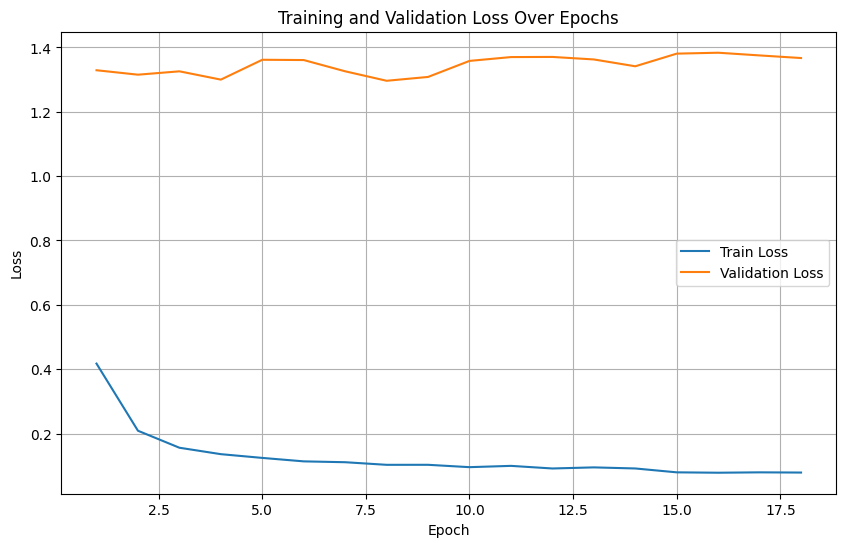

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib
import matplotlib.pyplot as plt

# 1. Centralized Configuration
"""
This dictionary holds all hyperparameters and settings for the training process.
Modifying these values will directly impact the model's architecture, data handling,
and training behavior.
"""
CONFIG = {
    # Data and Target Specification
    "train_data_path": "/content/drive/MyDrive/traindata.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],

    # Model Architecture
    "window_size": 30,
    "future_steps": 1200,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.3,
    "model_type": "BiLSTM",

    # Training Parameters
    "learning_rate": 0.001,
    "weight_decay": 1e-5,
    "batch_size": 32,
    "num_epochs": 200,
    "early_stopping_patience": 10,
    "validation_split": 0.2,
}
# The model's output layer size is derived from the number of targets and future steps.
CONFIG["output_size"] = len(CONFIG["target_columns"]) * CONFIG["future_steps"]


# 2. Data Preparation
"""
This section contains functions and classes for preparing the time series data
for the direct multi-step forecasting model.
"""

def create_direct_sequences(data, target_column_indices, window_size, future_steps):
    """
    Creates sequences where X is the history and y is the entire future trajectory.
    The future trajectory is flattened into a single target vector.
    """
    X, y = [], []
    num_samples = len(data) - window_size - future_steps + 1

    if num_samples <= 0:
        raise ValueError(
            f"Not enough data to create sequences. "
            f"Total data points: {len(data)}, Window size: {window_size}, Future steps: {future_steps}. "
            f"Need at least {window_size + future_steps} data points."
        )

    for i in range(num_samples):
        # Input sequence (the history)
        X.append(data[i : i + window_size, :])

        # Output sequence (the entire future, flattened)
        future_sequence = data[i + window_size : i + window_size + future_steps, target_column_indices]
        y.append(future_sequence.flatten())

    return np.array(X), np.array(y)


class TimeSeriesDataset(Dataset):
    """A custom PyTorch Dataset for handling time series sequence data."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 3. Model Architecture
"""
This section defines the neural network architecture for the direct forecasting model.
"""
class BiLSTMModel(nn.Module):
    """
    A Bidirectional LSTM model that takes a historical window and predicts
    a flattened vector representing the entire future sequence in one shot.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # The final fully connected layer maps the LSTM output to the desired future sequence size.
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We use the output of the final time step from the historical sequence to make the prediction.
        out = self.fc(lstm_out[:, -1, :])
        return out


# 4. Training Function
"""
This section contains the main training loop, including validation,
model saving, and early stopping logic.
"""
def train_model(model, config, train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=config["early_stopping_patience"] // 2, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    model_save_path = f"model_{config['model_type']}.pth"

    # Lists to store loss for plotting
    train_losses = []
    val_losses = []

    print(f"Starting Training for {config['model_type']} (Direct Multi-Step Method)")
    for epoch in range(config["num_epochs"]):
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        scheduler.step(avg_val_loss)

        # Early stopping and model saving logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
            print(f"    => New best model saved to '{model_save_path}' with validation loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1

        if patience_counter >= config['early_stopping_patience']:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    print("Training Complete")

    # Plotting the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


# 5. Main Execution Block
"""
This main function orchestrates the entire process: loading data, scaling,
creating sequences, splitting data, and initiating the model training.
"""
def main():
    try:
        dff_train = pd.read_csv(CONFIG["train_data_path"])
        dff_train_numeric = dff_train.select_dtypes(include=[np.number])
    except FileNotFoundError:
        print(f"FATAL: Training data file not found at '{CONFIG['train_data_path']}'.")
        return

    # Validate that all specified target columns exist in the dataframe
    for col in CONFIG["target_columns"]:
        if col not in dff_train_numeric.columns:
            print(f"FATAL: Target column '{col}' not found in the training data.")
            return

    # Scale the data and save the scaler for later use
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dff_train_numeric)
    joblib.dump(scaler, "main_scaler.joblib")
    print("Main scaler saved to 'main_scaler.joblib'")

    # Create the specialized sequences for direct forecasting
    target_col_indices = [dff_train_numeric.columns.get_loc(c) for c in CONFIG["target_columns"]]
    try:
        Xt, yt = create_direct_sequences(data_scaled, target_col_indices, CONFIG["window_size"], CONFIG["future_steps"])
    except ValueError as e:
        print(f"FATAL: Error creating sequences: {e}")
        return

    # Split the data into training and validation sets
    split_index = int(len(Xt) * (1 - CONFIG["validation_split"]))
    if split_index == 0 or split_index == len(Xt):
        print("FATAL: Validation split resulted in an empty training or validation set.")
        return

    X_train, X_val = Xt[:split_index], Xt[split_index:]
    y_train, y_val = yt[:split_index], yt[split_index:]

    # Create PyTorch Datasets and DataLoaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

    # Initialize and train the model
    input_size = X_train.shape[2]
    model = BiLSTMModel(
        input_size=input_size,
        hidden_size=CONFIG["hidden_size"],
        num_layers=CONFIG["num_layers"],
        output_size=CONFIG["output_size"],
        dropout=CONFIG["dropout"]
    )
    train_model(model, CONFIG, train_loader, val_loader)


if __name__ == '__main__':
    main()

--- Starting Model Evaluation (Rolling Forecast) ---
Scaler loaded from 'main_scaler.joblib'
Test data loaded and processed.
Model loaded from 'model_BiLSTM.pth'
Generating one-step-ahead predictions...
Plotting results...


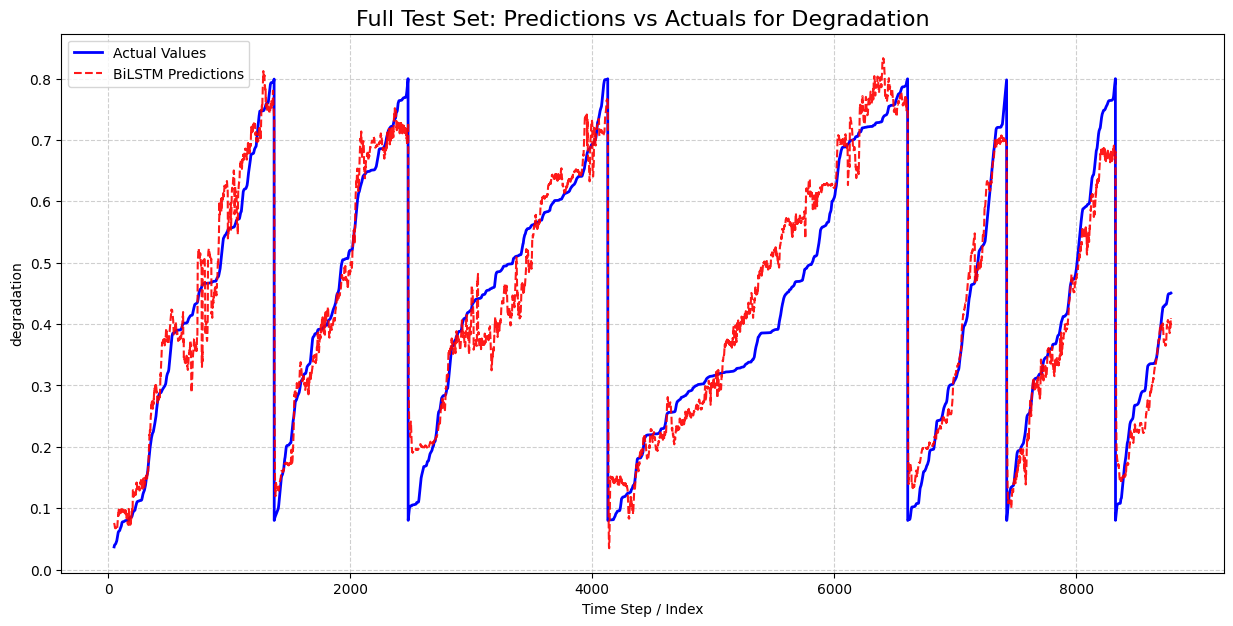

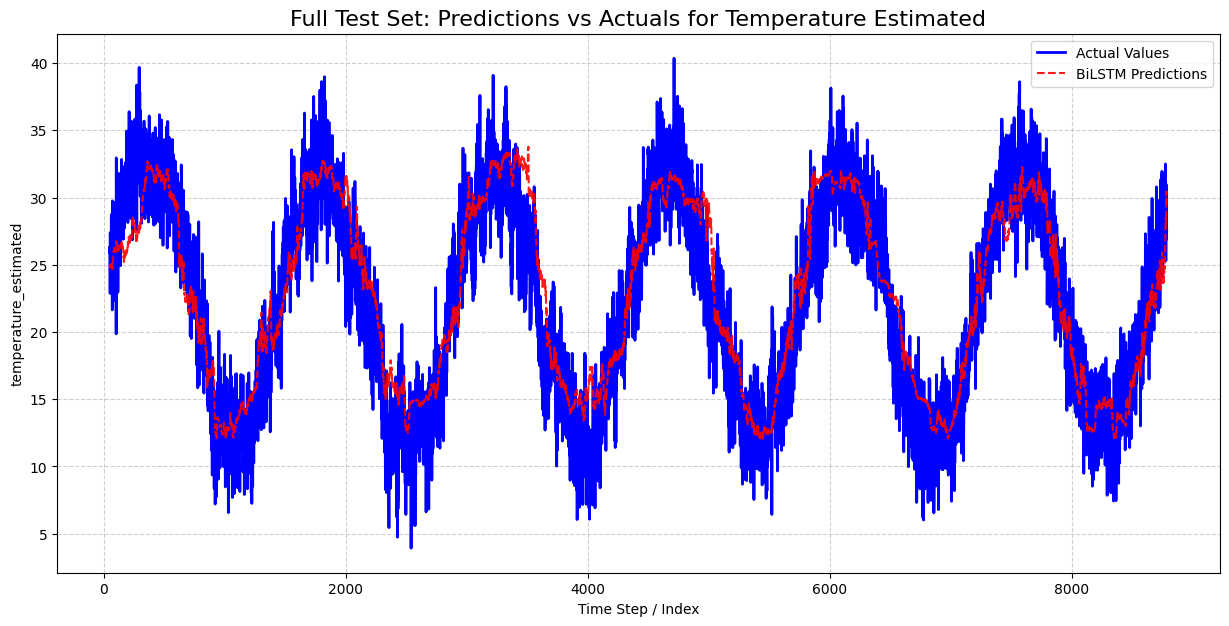

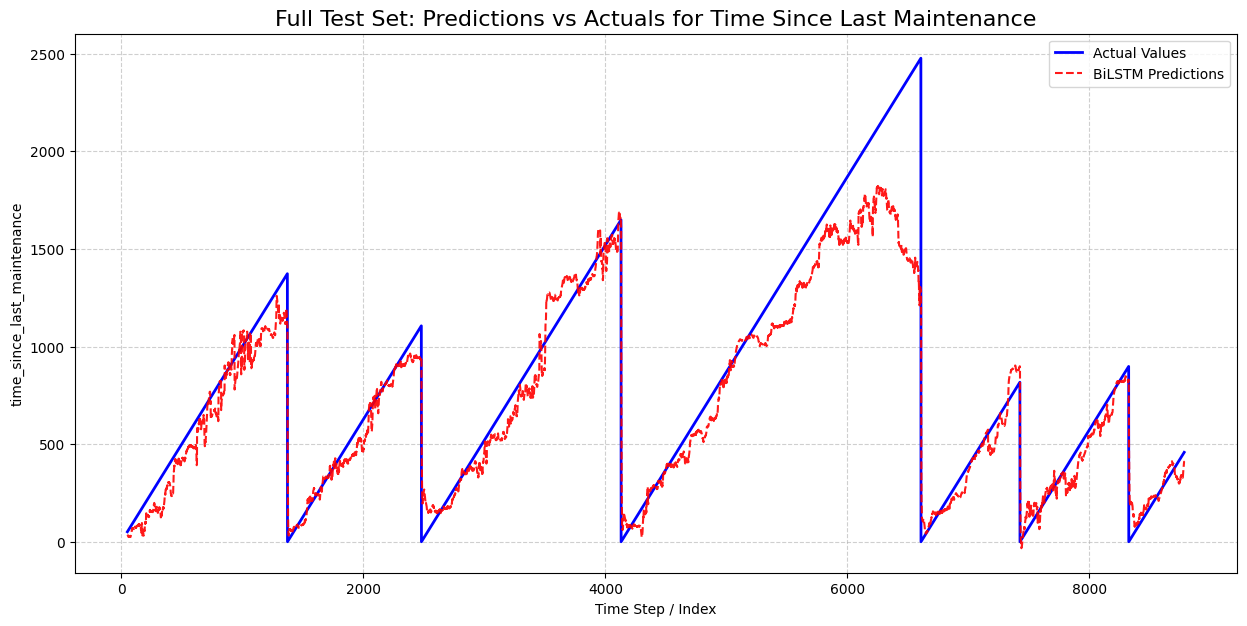

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib

# 1. Configuration for Evaluation
"""
Holds all parameters for running the evaluation. These settings must exactly
match the configuration of the trained model to ensure correct loading and
accurate results.
"""
EVAL_CONFIG = {
    "model_path": "model_BiLSTM.pth",
    "model_type": "BiLSTM",
    "scaler_path": "main_scaler.joblib",
    "test_data_path": "/content/drive/MyDrive/testdata.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],
    "window_size": 50,
    "future_steps": 1200,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.2
}
# Derived configuration, calculated automatically.
EVAL_CONFIG["output_size"] = len(EVAL_CONFIG["target_columns"]) * EVAL_CONFIG["future_steps"]


# 2. Model Architecture
"""
This class defines the structure of the model. It must be identical to the
one used for training to allow for correct weight loading.
"""
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # The final layer maps the bidirectional LSTM output to the flattened prediction vector.
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Use the final hidden state to make a single prediction for the entire future.
        out = self.fc(lstm_out[:, -1, :])
        return out


# 3. Helper Function
"""
This section contains the helper function for creating input sequences from data.
"""
def create_input_sequence(data, window_size):
    """Creates all possible historical sequences (X) from the provided data."""
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
    return np.array(X)


# 4. Main Evaluation Block
"""
This main function orchestrates the evaluation process: loading artifacts,
processing test data, generating predictions, and plotting the results.
"""
def run_evaluation():
    print("--- Starting Model Evaluation (Rolling Forecast) ---")

    # Load the scaler
    try:
        scaler = joblib.load(EVAL_CONFIG["scaler_path"])
        print(f"Scaler loaded from '{EVAL_CONFIG['scaler_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Scaler file not found. Run the training script first.")
        return

    # Load the test data
    try:
        dff_test = pd.read_csv(EVAL_CONFIG["test_data_path"])
        dff_test_numeric = dff_test.select_dtypes(include=[np.number])
        test_aligned = dff_test_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
        test_scaled = scaler.transform(test_aligned)

        # Create all possible input sequences from the test data
        X_test = create_input_sequence(test_scaled, EVAL_CONFIG["window_size"])
        print("Test data loaded and processed.")
    except Exception as e:
        print(f"FATAL: Error processing test data: {e}.")
        return

    # Initialize and load the trained model
    model = BiLSTMModel(
        input_size=X_test.shape[2],
        hidden_size=EVAL_CONFIG["hidden_size"],
        num_layers=EVAL_CONFIG["num_layers"],
        output_size=EVAL_CONFIG["output_size"],
        dropout=EVAL_CONFIG["dropout"]
    )
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(EVAL_CONFIG["model_path"], map_location=device))
        model.to(device)
        model.eval()
        print(f"Model loaded from '{EVAL_CONFIG['model_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Model file not found. Make sure you have trained the direct multi-step model.")
        return

    # Generate one-step-ahead predictions for the entire test set
    all_predictions_scaled = []
    print("Generating one-step-ahead predictions...")
    with torch.no_grad():
        for i in range(len(X_test)):
            input_tensor = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0).to(device)
            flat_prediction_scaled = model(input_tensor)

            # Reshape the prediction and take only the first step of the forecast
            prediction_for_all_targets = flat_prediction_scaled.cpu().numpy().reshape(EVAL_CONFIG["future_steps"], len(EVAL_CONFIG["target_columns"]))
            first_step_prediction = prediction_for_all_targets[0]
            all_predictions_scaled.append(first_step_prediction)

    all_predictions_scaled = np.array(all_predictions_scaled)

    # Process predictions for unscaling
    prediction_full = np.zeros((len(all_predictions_scaled), len(scaler.feature_names_in_)))
    target_indices = [list(scaler.feature_names_in_).index(c) for c in EVAL_CONFIG["target_columns"]]
    prediction_full[:, target_indices] = all_predictions_scaled
    prediction_unscaled = scaler.inverse_transform(prediction_full)

    # Get the ground truth (actual data) for comparison
    actual_data_unscaled = test_aligned.iloc[EVAL_CONFIG["window_size"]:]

    # Create a comparison DataFrame
    output_df = pd.DataFrame(index=actual_data_unscaled.index)
    for i, target_name in enumerate(EVAL_CONFIG["target_columns"]):
        output_df[target_name] = actual_data_unscaled[target_name]
        # Get the correct column from the unscaled predictions
        prediction_col_idx = target_indices[i]
        output_df[f'predicted_{target_name}'] = prediction_unscaled[:, prediction_col_idx]

    # Create plots for each target variable
    print("Plotting results...")
    for target_name in EVAL_CONFIG["target_columns"]:
        plt.figure(figsize=(15, 7))

        # Plot actual and predicted values
        plt.plot(output_df.index, output_df[target_name], label='Actual Values', color='blue', linestyle='-', linewidth=2)
        plt.plot(output_df.index, output_df[f'predicted_{target_name}'], label=f'{EVAL_CONFIG["model_type"]} Predictions', color='red', linestyle='--', alpha=0.9)

        # Formatting
        plt.title(f'Full Test Set: Predictions vs Actuals for {target_name.replace("_", " ").title()}', fontsize=16)
        plt.xlabel('Time Step / Index')
        plt.ylabel(target_name)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


if __name__ == '__main__':
    run_evaluation()

--- Starting Model Evaluation (Rolling Forecast) ---
Scaler loaded from 'main_scaler.joblib'
Test data loaded and processed.
Model loaded from 'model_BiLSTM.pth'
Generating one-step-ahead predictions...
Plotting results...


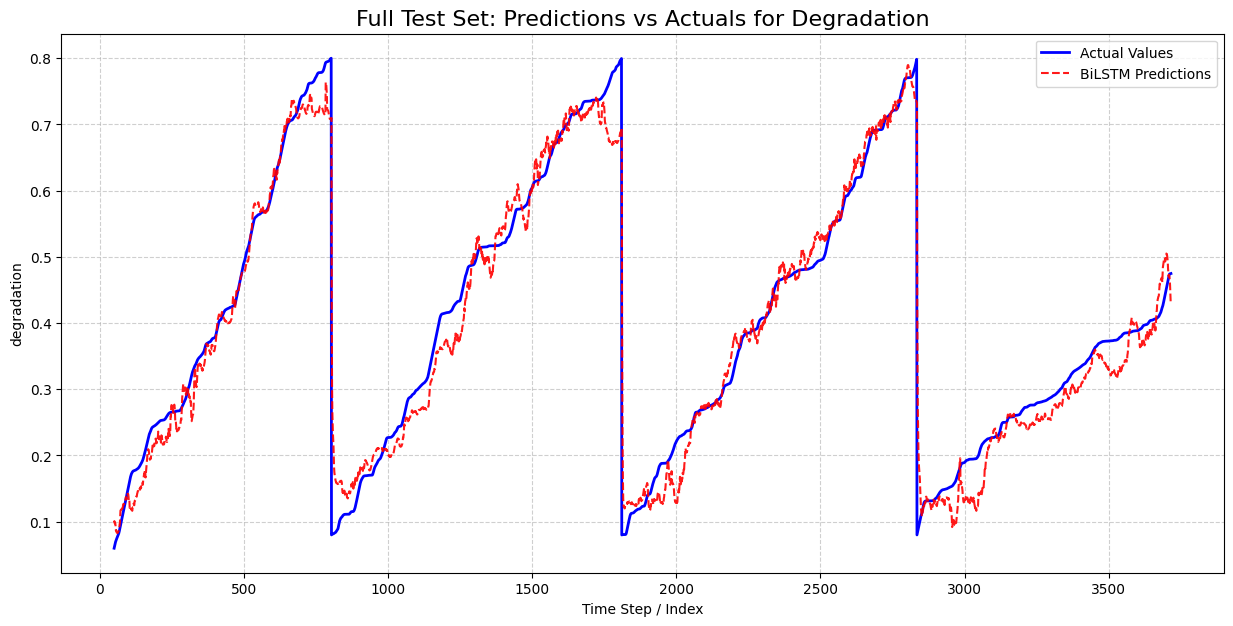

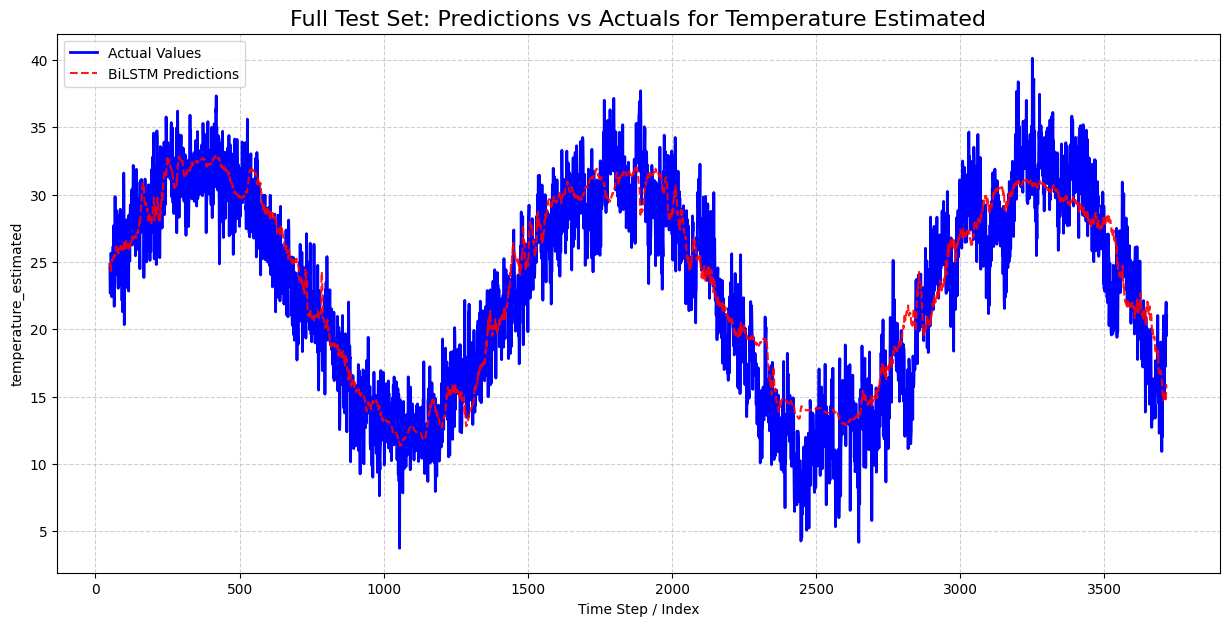

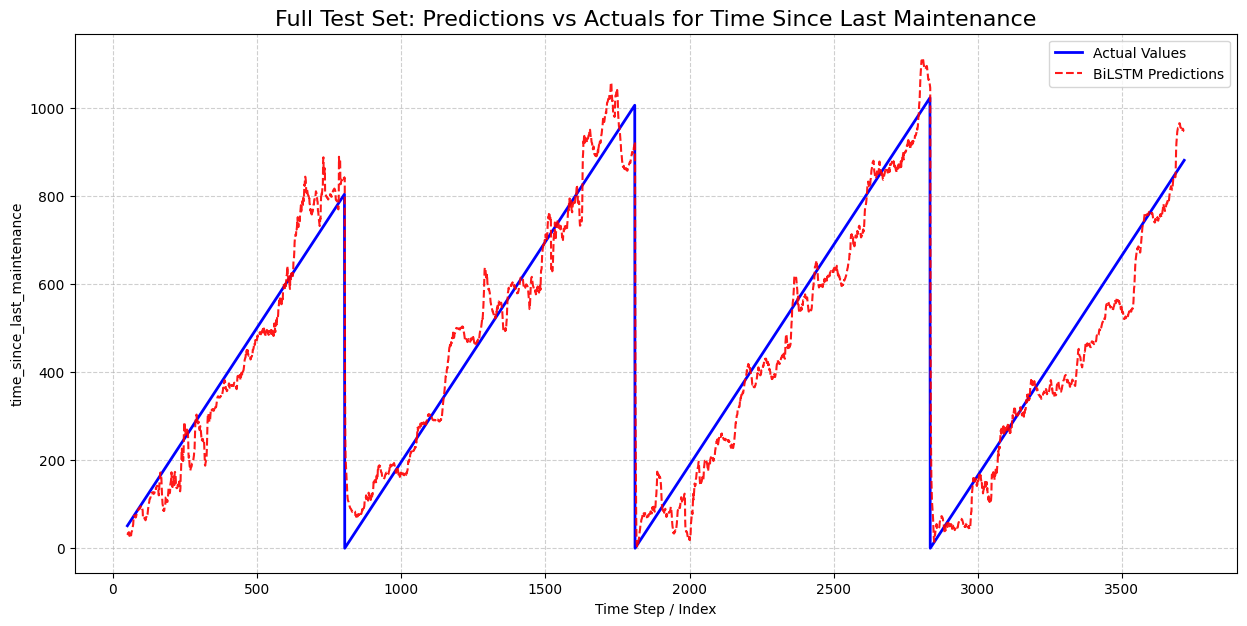

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib

# 1. Configuration for Evaluation
"""
Holds all parameters for running the evaluation. These settings must exactly
match the configuration of the trained model to ensure correct loading and
accurate results.
"""
EVAL_CONFIG = {
    "model_path": "model_BiLSTM.pth",
    "model_type": "BiLSTM",
    "scaler_path": "main_scaler.joblib",
    "test_data_path": "/content/drive/MyDrive/2025updated.csv",
    "target_columns": ["degradation", "temperature_estimated", "time_since_last_maintenance"],
    "window_size": 50,
    "future_steps": 1200,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0.2
}
# Derived configuration, calculated automatically.
EVAL_CONFIG["output_size"] = len(EVAL_CONFIG["target_columns"]) * EVAL_CONFIG["future_steps"]


# 2. Model Architecture
"""
This class defines the structure of the model. It must be identical to the
one used for training to allow for correct weight loading.
"""
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # The final layer maps the bidirectional LSTM output to the flattened prediction vector.
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Use the final hidden state to make a single prediction for the entire future.
        out = self.fc(lstm_out[:, -1, :])
        return out


# 3. Helper Function
"""
This section contains the helper function for creating input sequences from data.
"""
def create_input_sequence(data, window_size):
    """Creates all possible historical sequences (X) from the provided data."""
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
    return np.array(X)


# 4. Main Evaluation Block
"""
This main function orchestrates the evaluation process: loading artifacts,
processing test data, generating predictions, and plotting the results.
"""
def run_evaluation():
    print("--- Starting Model Evaluation (Rolling Forecast) ---")

    # Load the scaler
    try:
        scaler = joblib.load(EVAL_CONFIG["scaler_path"])
        print(f"Scaler loaded from '{EVAL_CONFIG['scaler_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Scaler file not found. Run the training script first.")
        return

    # Load the test data
    try:
        dff_test = pd.read_csv(EVAL_CONFIG["test_data_path"])
        dff_test_numeric = dff_test.select_dtypes(include=[np.number])
        test_aligned = dff_test_numeric.reindex(columns=scaler.feature_names_in_, fill_value=0)
        test_scaled = scaler.transform(test_aligned)

        # Create all possible input sequences from the test data
        X_test = create_input_sequence(test_scaled, EVAL_CONFIG["window_size"])
        print("Test data loaded and processed.")
    except Exception as e:
        print(f"FATAL: Error processing test data: {e}.")
        return

    # Initialize and load the trained model
    model = BiLSTMModel(
        input_size=X_test.shape[2],
        hidden_size=EVAL_CONFIG["hidden_size"],
        num_layers=EVAL_CONFIG["num_layers"],
        output_size=EVAL_CONFIG["output_size"],
        dropout=EVAL_CONFIG["dropout"]
    )
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(EVAL_CONFIG["model_path"], map_location=device))
        model.to(device)
        model.eval()
        print(f"Model loaded from '{EVAL_CONFIG['model_path']}'")
    except FileNotFoundError:
        print(f"FATAL: Model file not found. Make sure you have trained the direct multi-step model.")
        return

    # Generate one-step-ahead predictions for the entire test set
    all_predictions_scaled = []
    print("Generating one-step-ahead predictions...")
    with torch.no_grad():
        for i in range(len(X_test)):
            input_tensor = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0).to(device)
            flat_prediction_scaled = model(input_tensor)

            # Reshape the prediction and take only the first step of the forecast
            prediction_for_all_targets = flat_prediction_scaled.cpu().numpy().reshape(EVAL_CONFIG["future_steps"], len(EVAL_CONFIG["target_columns"]))
            first_step_prediction = prediction_for_all_targets[0]
            all_predictions_scaled.append(first_step_prediction)

    all_predictions_scaled = np.array(all_predictions_scaled)

    # Process predictions for unscaling
    prediction_full = np.full((len(all_predictions_scaled), len(scaler.feature_names_in_)), scaler.mean_)
    target_indices = [list(scaler.feature_names_in_).index(c) for c in EVAL_CONFIG["target_columns"]]
    prediction_full[:, target_indices] = all_predictions_scaled
    prediction_unscaled = scaler.inverse_transform(prediction_full)

    # Get the ground truth (actual data) for comparison
    actual_data_unscaled = test_aligned.iloc[EVAL_CONFIG["window_size"]:]

    # Create a comparison DataFrame
    output_df = pd.DataFrame(index=actual_data_unscaled.index)
    for i, target_name in enumerate(EVAL_CONFIG["target_columns"]):
        output_df[target_name] = actual_data_unscaled[target_name]
        # Get the correct column from the unscaled predictions
        prediction_col_idx = target_indices[i]
        output_df[f'predicted_{target_name}'] = prediction_unscaled[:, prediction_col_idx]

    # Create plots for each target variable
    print("Plotting results...")
    for target_name in EVAL_CONFIG["target_columns"]:
        plt.figure(figsize=(15, 7))

        # Plot actual and predicted values
        plt.plot(output_df.index, output_df[target_name], label='Actual Values', color='blue', linestyle='-', linewidth=2)
        plt.plot(output_df.index, output_df[f'predicted_{target_name}'], label=f'{EVAL_CONFIG["model_type"]} Predictions', color='red', linestyle='--', alpha=0.9)

        # Formatting
        plt.title(f'Full Test Set: Predictions vs Actuals for {target_name.replace("_", " ").title()}', fontsize=16)
        plt.xlabel('Time Step / Index')
        plt.ylabel(target_name)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


if __name__ == '__main__':
    run_evaluation()